# Bayesian RL Single Subject

Before establishing an ierarchical model, first consider a Bayes RL model per subject.


##### References:

- (Bayes RL in PyMC3)(https://github.com/ricardoV94/stats/blob/master/modelling/RL_PyMC.ipynb)


In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# import pymc3 as pm
# import theano
# import theano.tensor as tt
# import arviz as az

In [2]:
# plot -------------------------------------------------------------------------------------------*
def plot_data(actions, rewards, Qs):
    
    plt.figure(figsize=(20,3))
    x = np.arange(len(actions))

    plt.plot(x, Qs[:, 0] - .5 + 0, c='C0', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 1] - .5 + 1, c='C1', lw=3, alpha=.3)

    s = 50
    lw = 2

    cond = (actions == 0) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C0', lw=lw)

    cond = (actions == 0) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C0', ec='C0', lw=lw)

    cond = (actions == 1) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C1', lw=lw)

    cond = (actions == 1) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C1', ec='C1', lw=lw)

    plt.scatter(0, 20, c='k', s=s, lw=lw, label='Reward')
    plt.scatter(0, 20, c='w', ec='k', s=s, lw=lw, label='No reward')
    plt.plot([0,1], [20, 20], c='k', lw=3, alpha=.3, label='Qvalue (centered)')


    plt.yticks([0,1], ['left', 'right'])
    plt.ylim(-1, 2)

    plt.ylabel('action')
    plt.xlabel('trial')

    handles, labels = plt.gca().get_legend_handles_labels()
    order = (1,2,0)
    handles = [handles[idx] for idx in order]
    labels = [labels[idx] for idx in order]

    plt.legend(handles, labels, fontsize=12, loc=(1.01, .27))
    plt.tight_layout()
# plot -------------------------------------------------------------------------------------------*




# generate artificial data -----------------------------------------------------------------------*
def generate_data(alpha, beta, n=100, p_r=[.4, .6]):
    actions = np.zeros(n, dtype=np.int)
    rewards = np.zeros(n, dtype=np.int)
    Qs = np.zeros((n, 2))

    # Initialize Q table
    Q = np.array([.5, .5])
    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(beta*Q)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = np.random.choice([0, 1], p=prob_a)
        r = np.random.rand() < p_r[a]

        # Update Q table
        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs
# generate artificial data -----------------------------------------------------------------------*

/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_42781/1698389103.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actions = np.zeros(n, dtype=np.int)
/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_42781/1698389103.py:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

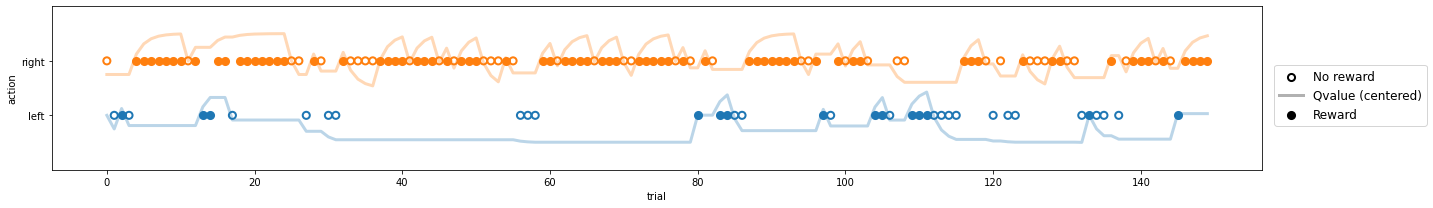

In [3]:
true_alpha = .5
true_beta = 5
n = 150
actions, rewards, Qs = generate_data(true_alpha, true_beta, n)
plot_data(actions, rewards, Qs)

# Fitting the model with MLE

In [7]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Initialize values
    Q = np.array([.5, .5])
    log_prob_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions,rewards)):
        # Apply the softmax transformation
        Q_ = Q * beta
        log_prob_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        log_prob_actions[t] = log_prob_action[a]

        # Update the Q values for the next trial
        Q[a] = Q[a] + alpha * (r - Q[a])

    # Return the negative log likelihood of all observed actions
    return -np.sum(log_prob_actions[1:])


llik_td([true_alpha, true_beta], *(actions, rewards))


55.07796690129935

In [8]:
x0 = [true_alpha, true_beta]
result = scipy.optimize.minimize(llik_td, x0, args=(actions, rewards), method='BFGS')
print(result)
print('')
print(f'MLE: alpha = {result.x[0]:.2f} (true value = {true_alpha})')
print(f'MLE: beta = {result.x[1]:.2f} (true value = {true_beta})')

      fun: 55.059626567549884
 hess_inv: array([[ 0.00794081, -0.02933951],
       [-0.02933951,  0.70165135]])
      jac: array([-4.76837158e-07,  9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.48624994, 4.96294055])

MLE: alpha = 0.49 (true value = 0.5)
MLE: beta = 4.96 (true value = 5)


In [9]:
def llik_td_vectorized(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Create a list with the Q values of each trial
    Qs = np.ones((n, 2), dtype=np.float)
    Qs[0] = .5
    for t, (a, r) in enumerate(zip(actions[:-1], rewards[:-1])):  # The last Q values were never used, so there is no need to compute them
        Qs[t+1, a] = Qs[t, a] + alpha * (r - Qs[t, a])
        Qs[t+1, 1-a] = Qs[t, 1-a]

    # Apply the softmax transformation in a vectorized way
    Qs_ = Qs * beta
    log_prob_actions = Qs_ - scipy.special.logsumexp(Qs_, axis=1)[:, None]

    # Return the log_prob_actions for the observed actions
    log_prob_actions = log_prob_actions[np.arange(len(actions)), actions]
    return -np.sum(log_prob_actions[1:])



llik_td_vectorized([true_alpha, true_beta], *(actions, rewards))


/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_42781/3727008196.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Qs = np.ones((n, 2), dtype=np.float)


55.07796690129935

# PyMC3


```
# P(A=R | Q) --------------------------------------------------------------------------------------------------------------*
def right_action_probs(alpha, beta, actions, rewards):
    rewards = theano.shared(np.asarray(rewards, dtype='int16'))
    actions = theano.shared(np.asarray(actions, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((2), dtype='float64')
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])

    # Apply the sotfmax transformation
    Qs_ = Qs[:-1] * beta
    log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

    # Return the probabilities for the right action, in the original scale
    return tt.exp(log_prob_actions[:, 1]) 
# P(A=R | Q) --------------------------------------------------------------------------------------------------------------*


# Define Model ------------------------------------------------------------------------------------------------------------*
with pm.Model() as m_alt:
    alpha = pm.Beta('alpha', 1, 1)
    beta = pm.HalfNormal('beta', 10)

    action_probs = right_action_probs(alpha, beta, actions, rewards)
    like = pm.Bernoulli('like', p=action_probs, observed=actions_[1:])

    tr_alt = pm.sample()
# Define Model ------------------------------------------------------------------------------------------------------------*

az.plot_trace(tr_alt);
```

In [161]:
%%capture
# !pip install arviz==0.6.1
!conda install -c conda-forge arviz

In [162]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# !conda install mkl-service -y
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

In [163]:
def update_Q(action, reward,
             Qs,
             alpha):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """

    Qs = tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    return Qs

In [164]:
# Transform the variables into appropriate Theano objects
rewards_ = theano.shared(np.asarray(rewards, dtype='int16'))
actions_ = theano.shared(np.asarray(actions, dtype='int16'))

alpha = tt.scalar("alpha")
beta = tt.scalar("beta")

# Initialize the Q table
Qs = 0.5 * tt.ones(2, dtype='float64')

# Compute the Q values for each trial
Qs, _ = theano.scan(
    fn=update_Q,
    sequences=[actions_, rewards_],
    outputs_info=[Qs],
    non_sequences=[alpha])

# # Apply the softmax transformation
# Qs_ = Qs * beta
# log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

# # Calculate the negative log likelihod of the observed actions
# log_prob_actions = log_prob_actions[tt.arange(actions_.shape[0]-1), actions_[1:]]
# neg_log_like = -tt.sum(log_prob_actions)

ValueError: Cannot compute test value: input 0 (alpha) of Op Elemwise{mul,no_inplace}(alpha, Elemwise{sub,no_inplace}.0) missing default value.  
Backtrace when that variable is created:

  File "/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
    result = self._run_cell(
  File "/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
    return runner(coro)
  File "/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_51733/584478288.py", line 5, in <module>
    alpha = tt.scalar("alpha")


In [159]:
def right_action_probs(alpha, beta, actions, rewards):
    rewards = theano.shared(np.asarray(rewards, dtype='int16'))
    actions = theano.shared(np.asarray(actions, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((2), dtype='float64')
    Qs, updates = theano.scan(
        fn=update_Q,
        sequences=[actions, rewards],
        outputs_info=[Qs],
        non_sequences=[alpha])

    # Apply the sotfmax transformation
    Qs_ = Qs[:-1] * beta
    log_prob_actions = Qs_ - pm.math.logsumexp(Qs_, axis=1)

    # Return the probabilities for the right action, in the original scale
    return tt.exp(log_prob_actions[:, 1]) 

In [160]:
with pm.Model() as m_alt:
    alpha = pm.Beta('alpha', 1, 1)
    beta = pm.HalfNormal('beta', 10)

    action_probs = right_action_probs(alpha, beta, actions, rewards)
    like = pm.Bernoulli('like', p=action_probs, observed=actions_[1:])

    tr_alt = pm.sample()

/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_51733/2929360235.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  tr_alt = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zachwolpe/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.


TypeError: from_pymc3() got an unexpected keyword argument 'save_warmup'

In [10]:

import logging
import os


import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

import pyro
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [11]:

import pyro.distributions as dist
import pyro.distributions.constraints as constraints

import graphviz

actions = torch.tensor(actions, dtype=torch.float)
rewards = torch.tensor(rewards, dtype=torch.float)



# with pyro.plate("data", len(ruggedness)):
#     return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

# result = torch.empty_like(ruggedness)
# for i in range(len(ruggedness)):
#     result[i] = pyro.sample(f"obs_{i}", dist.Normal(mean, sigma), obs=log_gdp[i] if log_gdp is not None else None)
# return result

In [47]:
# ASSUME ALPHA KNOWN ======= alpha=0.2 ========================================================*
Qs

log_prob_actions = []
for i in range(len(actions))[1:]:
    Qs[i, int(actions[i])] = Qs[i-1, int(actions[i])] + 1 * (rewards[i] - Qs[i-1, int(actions[i])])

Qs = torch.tensor(Qs)


len(log_prob_actions)

/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_42781/3235073997.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Qs = torch.tensor(Qs)


0

In [71]:



def model_alpha_known(Qs, rewards=None):
    # alpha = pyro.param('alpha', lambda:torch.randn(())) #pyro.param('alpha', lambda:torch.randn(()), constraint=constraints.interval(0,1))
    # alpha = 0.2
    beta  = pyro.param('beta', lambda:torch.randn(()))
    pyro.sample("sigma", dist.Uniform(0., 10.))
    beta = pyro.sample("beta", dist.BetaBinomial(10.))
#     beta = pm.HalfNormal('beta', 10)
# pyro.dis


    # compute prob of action
    Qs_ = Qs * beta
    log_prob_actions = torch.exp(Qs_[:,0]) / torch.exp(Qs_).sum(axis=1)


    with pyro.plate("data", len(actions)):
        return pyro.sample(f"obs_{i}", dist.Bernoulli(log_prob_actions), obs=rewards if rewards is not None else None)




pyro.render_model(model_alpha_known, model_args=(Qs, rewards))

TypeError: __init__() missing 1 required positional argument: 'concentration0'

In [68]:
auto_guide = pyro.infer.autoguide.AutoNormal(model_alpha_known)

adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model_alpha_known, auto_guide, adam, elbo)




Elbo loss: 121.74822998046875
Elbo loss: 87.70138549804688
Elbo loss: 83.97325134277344
Elbo loss: 83.7242431640625
Elbo loss: 83.7142333984375
Elbo loss: 83.71404266357422
Elbo loss: 83.71404266357422
Elbo loss: 83.71404266357422
Elbo loss: 83.71404266357422
Elbo loss: 83.71404266357422


CPU times: user 389 ms, sys: 15 ms, total: 404 ms
Wall time: 412 ms


Text(0, 0.5, 'ELBO loss')

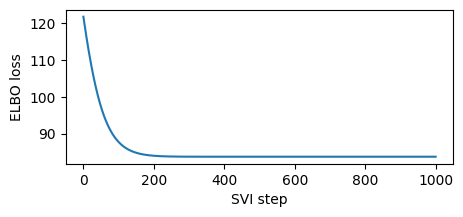

In [69]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model_alpha_known)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model_alpha_known, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(Qs, rewards)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [70]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

beta -1.8703369


In [90]:
Qs = np.zeros((len(actions), 2))
Qs[0] = 0.5
Qs


beta = torch.tensor(4, dtype=torch.float)


for i in range(len(actions))[1:]:
    Qs[i, int(actions[i])] = Qs[i-1, int(actions[i])] + 0.2*(rewards[i] - Qs[i-1, int(actions[i])])
    Qs_                 = Qs[i, :] * np.array(beta)
    # log_prob_actions    = Qs_ - scipy.special.logsumexp(Qs_) # LIKELIHOOD!
    log_prob_actions    =np.exp(Qs_[0]) / np.exp(Qs_).sum()



# vectorized transformation
# beta = torch.tensor(4, dtype=torch.float)
# Qs_ = Qs * np.array(beta)
# log_prob_actions = Qs_ - scipy.special.logsumexp(Qs_, axis=1)[:, None]
beta

0.16798161153384708
0.6899744836776147
0.5
0.5
0.5
0.5
0.3100255163223853
0.34524654262737153
0.2121523581411687
0.6899744836776147
0.5
0.3100255163223853
0.34524654262737153
0.6899744836776147
0.6547534573726285
0.3100255163223853
0.19154533970055182
0.12433542688617182
0.08614813578444787
0.1313265759581617
0.5
0.3100255163223853
0.34524654262737153
0.3747248042686269
0.2297718389925788
0.1458310896548561
0.1955812740510265
0.12660508063667383
0.08745985090154597
0.06440196185937254
0.050171535121918916
0.08685402992246898
0.06403588928627364
0.04993981075313376
0.040833360077085795
0.034714974189957185
0.030466073717982267
0.059069125704806394
0.046773801084141364
0.038730656797608204
0.033268864476798186
0.029442289277327248
0.057521682180629245
0.09646968813368437
0.6899744836776147
0.8084546602994482
0.7598760481937289
0.3100255163223853
0.19154533970055182
0.12433542688617182
0.08614813578444787
0.06360888810602555
0.10419823708702478
0.1517244866460125
0.10184310245939941
0.072

tensor(4.)

In [85]:
Qs_ - scipy.special.logsumexp(Qs_)

array([-1.78390076, -0.18390074])

In [88]:
np.exp(Qs_[0]) / np.exp(Qs_).sum()

0.16798161153384708